# **Homework 9: Variational Autoencoders**

## **About**

### **Due**

Monday 4/22/19, 11:59 PM CST

### **Goal**

This homework focuses on creating variational autoencoders applied to the MNIST dataset.

## Dev Environment
### Working on Google Colab
You may choose to work locally or on Google Colaboratory. You have access to free compute through this service. 
1. Visit https://colab.research.google.com/drive 
2. Navigate to the **`Upload`** tab, and upload your `HW10.ipynb`
3. Now on the top right corner, under the `Comment` and `Share` options, you should see a `Connect` option. Once you are connected, you will have access to a VM with 12GB RAM, 50 GB disk space and a single GPU. The dropdown menu will allow you to connect to a local runtime as well.

**Notes:** 
* **If you do not have a working setup for Python 3, this is your best bet. It will also save you from heavy installations like `tensorflow` if you don't want to deal with those.**
* ***There is a downside*. You can only use this instance for a single 12-hour stretch, after which your data will be deleted, and you would have redownload all your datasets, any libraries not already on the VM, and regenerate your logs**.


### Installing PyTorch and Dependencies

The instructions for installing and setting up PyTorch can be found at https://pytorch.org/get-started/locally/. Make sure you follow the instructions for your machine. For any of the remaining libraries used in this assignment:
* We have provided a `hw8_requirements.txt` file on the homework web page. 
* Download this file, and in the same directory you can run `pip3 install -r hw8_requirements.txt`

Check that PyTorch installed correctly by running the following:

In [1]:
import torch
torch.rand(5, 3)

tensor([[0.6018, 0.1180, 0.4210],
        [0.1014, 0.5055, 0.3165],
        [0.7543, 0.8159, 0.6591],
        [0.5155, 0.2527, 0.1819],
        [0.4028, 0.1405, 0.9907]])

The output should look something like

```python
tensor([[0.3380, 0.3845, 0.3217],
        [0.8337, 0.9050, 0.2650],
        [0.2979, 0.7141, 0.9069],
        [0.1449, 0.1132, 0.1375],
        [0.4675, 0.3947, 0.1426]])
```

### Let's get started with the assignment.

## **Instructions**

### **Part 1 - Datasets and Dataloaders**

This part of the assignment is similar to HW 8. 

**Create a directory named hw9_data with the following command.**

In [2]:
!mkdir hw9_data

mkdir: hw9_data: File exists



**Now use `torch.datasets.MNIST` to load the Train and Test data into `hw9_data`.** 
* ** Use the directory you created above as the `root` directory for your datasets**
* ** Populate the `transformations` variable with any transformations you would like to perform on your data.** (Hint: You will need to do at least one)
* **Pass your `transformations` variable to `torch.datasets.MNIST`. This allows you to perform arbitrary transformations to your data at loading time.**

In [3]:
from torchvision import datasets, transforms

## YOUR CODE HERE ##
transformations = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root = '/Users/xinqu/Sandbox/CS498 Applied Machine Learning/HW/HW9/hw9_data', 
                            train = True, transform = transformations, download = True) 
mnist_test = datasets.MNIST(root = '/Users/xinqu/Sandbox/CS498 Applied Machine Learning/HW/HW9/hw9_data', 
                            train = False, transform = transformations, download = True) 

**Any file in our dataset will now be read at runtime, and the specified transformations we need on it will be applied when we need it.**. 

We could iterate through these directly using a loop, but this is not idiomatic. PyTorch provides us with this abstraction in the form of `DataLoaders`. The module of interest is `torch.utils.data.DataLoader`. 

`DataLoader` allows us to do lots of useful things
* Group our data into batches
* Shuffle our data
* Load the data in parallel using `multiprocessing` workers

**Use `DataLoader` to create a loader for the training set and one for the testing set**
* **Use a `batch_size` of 32 to start, you may change it if you wish.**
* **Set the `shuffle` parameter to `True`.** 

**Check that the data was loaded successfully before proceeding to the next sections. **

In [4]:
from torch.utils.data import DataLoader

## YOUR CODE HERE ##
batch_size = 128
train_loader = DataLoader(dataset = mnist_train, shuffle = True, batch_size = batch_size)
test_loader = DataLoader(dataset = mnist_test, shuffle = True, batch_size = batch_size)

## **Part 2 - Encoder and Decoders (0 points)**

In this section we will be creating the encoder and decoder for our variational autoencoder (VAE). 

You can take a look at the following to understand how VAE's work. 

*   https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
*  http://kvfrans.com/variational-autoencoders-explained/
*  https://jmetzen.github.io/2015-11-27/vae.html

VAEs work around a latent space who's dimension can be chosen by us. We will leave this as a parameter for the Encoder and Decoder classes that you will have to populate. 

Feel free to use any network architecture that you wish. Try simpler network structures like a few linear layers before trying anything more complicated. 

### For the Encoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, 28,28)**
*  **forward() should return two tensors of size latent_dim like a standard encoder of a VAE**
* **One of the tensors should correspond to the mean of the encoding and the other tensor should correspond to the variance. In practice, it is easier to model the output as the log of the variance (logvar) and we will too**

### For the Decoder:

*   **Finish the __init__() function.**
*  **Finish the forward() function.** 
*  **Assume that input to forward, x, is of shape (batch_size, latent_dim)**
*  **forward() should return a tensor of shape (batch_size, 28,28)**
* **Make sure that the output lies in the same range as the input to the encoder (Hint: Sigmoid?)**







In [5]:
from torch.autograd import Variable
def to_var(x):
    return Variable(x)
def flatten(x):
    return to_var(x.view(x.size(0), -1))

In [6]:
from torch import nn
import torch.nn.functional as F
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, z_dim*2)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar
vae = VAE()
vae

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

## **Part 3: Training and loss functions** (0 points)

Recall that the encoder outputs the mean (mu) and the log of the variance (logvar). This implies that the latent vector of the input image follows a gaussian distribution with mean (mu) and standard deviation (e^[0.5\*logvar]). To decode this information, the decoder needs a sample from this distribution. 

**Complete the sample function to generate these samples **

In [7]:
def sample(mu, logvar):
    ## YOUR CODE HERE ##
    #return 
    pass

We also need to create the loss function. Assume that x are your input images and x_hat are your reconstructions of these input images, complete the following loss for a VAE. (Hint: You will need to use mu and logvar as well)

In [8]:
def vae_loss(x_hat, x, mu, logvar):
  ## YOUR CODE HERE ##
  # MSE LOSS + KL DIVERGENCE 
    MSE = F.mse_loss(x_hat.view(-1, 784), x.view(-1, 784), reduction = 'sum')
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In the following we will instantiate an Encoder and Decoder with a latent dimension of 32.

We also define a single optimizer that optimizes the parameters of both the Encoder and the Decoder together. Feel free to use any optimizer of your choice. 

In [9]:
#from torch import optim

## YOUR CODE HERE ##
encoder = None
decoder = None
#params = list(encoder.parameters())+list(encoder.parameters())
#optimizer = optim.Adam(params, lr=1e-3)

Complete the train function that takes input encoder, decoder, train_loader, optimizer, and number of epochs you wish to train your model for.

Training will involve:

1.   **One epoch is defined as a full pass of your dataset through your model. We choose the number of epochs we wish to train our model for.**
2.   **For each batch, use the encoder to generate the mu and logvar.**
3. **Sample a latent vector for each image in the batch and feed this to the decoder to generate the decoded images.**
4. **Calculate the loss function for this batch.**
5. **Now calculate the gradients for each parameter you are optimizing over. (Hint: Your loss function object can do this for you)**
6. **Update your model parameters (Hint: The optimizer comes in here)**
7. ** Set the gradients in your model to zero for the next batch.**



In [10]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
epochs = 10
for epoch in range(epochs):
    for idx, (images, _) in enumerate(train_loader):
        images = flatten(images)
        recon_images, mu, logvar = vae(images)
        loss = vae_loss(recon_images, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/batch_size))

Epoch[1/10] Loss: 28.431
Epoch[2/10] Loss: 24.869
Epoch[3/10] Loss: 24.294
Epoch[4/10] Loss: 24.421
Epoch[5/10] Loss: 23.296
Epoch[6/10] Loss: 24.089
Epoch[7/10] Loss: 24.137
Epoch[8/10] Loss: 24.325
Epoch[9/10] Loss: 23.376
Epoch[10/10] Loss: 23.122


Finally call train with the relevant parameters.

Note : This function may take a while to complete if you're training for many epochs on a cpu. This is where it comes in handy to be running on Google Colab, or just have a GPU on hand.

## **Part 4: Visualizing the VAE output** (90 points)

We will look at how well the codes produced by the VAE can be interpolated. **For this section we will only use the MNIST test set. **

To create an interpolation between two images A and B, we encode both these images and generate a sample code for each of them. We now consider 7 equally spaced points in between these two sample codes giving us a total of 9 points including the samples. We then decode these images to get interpolated images in between A and B.

Complete the interpolation function below that takes a pair of images A and B and returns 9 images. (You are free to use any data structure you want to return these images)

In [11]:
import matplotlib.pyplot as plt
from torchvision import utils
%matplotlib inline
import numpy as np

def create_interpolates(A, B, model):
  ## YOUR CODE HERE ##
    with torch.no_grad():
        imgs = []
        x, y, z = vae(flatten(A))
        mu = model.reparameterize(y, z)
        x1, y1, z1 = vae(flatten(B))
        mu1 = model.reparameterize(y1, z1)
        diff = mu - mu1 ###shape 1 * 32
        ###print(diff.shape)
        for i in range(9):
            tmp = mu + i / 8.0 * diff
            imgs.append(model.decoder(tmp))
        return imgs

**For 10 pairs of MNIST test images of the same digit (1 pair for "0", 1 pair for "1", etc.), selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows (1 row per digit) and 9 columns (7 interpolates + 2 selected test images) of images. (45 points)**

In [12]:
similar_pairs = {}
for _, (x, y) in enumerate(test_loader):
    for i in range(len(y)):
        if y[i].item() not in similar_pairs:
            similar_pairs[y[i].item()] = []
        if len(similar_pairs[y[i].item()])<2:
            similar_pairs[y[i].item()].append(x[i])

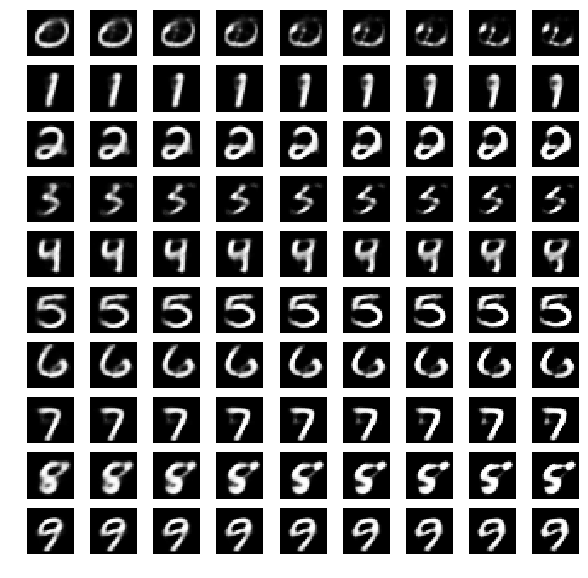

In [13]:
vae.eval()
f, ax = plt.subplots(nrows = 10, ncols = 9, figsize = (10, 10))
for digit in range(10):
    imgs = create_interpolates(similar_pairs[digit][0], similar_pairs[digit][1], vae)
    for i in range(9):
        ax[digit, i].axis('off')
        image = imgs[i].numpy().reshape(28, 28)
        ax[digit, i].imshow(image, cmap = 'gray')

**For 10 pairs of MNIST test images, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images. (45 points)**

In [16]:
random_pairs = {}
for _, (x, y) in enumerate(test_loader):
    # Make sure the batch size is greater than 20
    for i in range(10):
        random_pairs[i] = []
        random_pairs[i].append(x[2*i])
        random_pairs[i].append(x[2*i+1])
    break

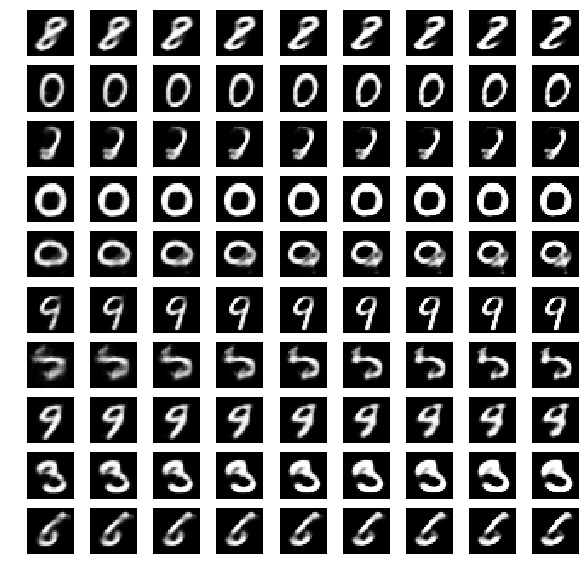

In [17]:
f, ax = plt.subplots(nrows = 10, ncols = 9, figsize = (10, 10))
for digit in range(10):
    imgs = create_interpolates(random_pairs[digit][0], random_pairs[digit][1], vae)
    for i in range(9):
        ax[digit, i].axis('off')
        image = imgs[i].numpy().reshape(28,28)
        ax[digit, i].imshow(image, cmap = 'gray')